In [1]:
#Importing essential libraries for project
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
#Base directory where 4 classes of images are stored
base_dir = "data"  

#skin aging categories
classes = ["Wrinkles", "Dark Spots", "Puffy Eyes", "Clear Skin"]

In [2]:
def build_df_from_folders(root, class_names, exts=(".jpg", ".jpeg", ".png")):
    paths, labs = [], []
    for c in class_names:
        p = os.path.join(root, c)
        if not os.path.isdir(p):
            print("Missing folder:", p)
            continue
        for f in os.listdir(p):
            if f.lower().endswith(exts):
                paths.append(os.path.join(p, f))
                labs.append(c)
    return pd.DataFrame({"filepath": paths, "label": labs})

In [3]:
#Building the dataframe
df = build_df_from_folders(base_dir, classes)

print("Total images:", len(df))
print(df["label"].value_counts())
df.head()



Total images: 1203
label
Dark Spots    303
Wrinkles      300
Puffy Eyes    300
Clear Skin    300
Name: count, dtype: int64


,filepath,label
0,data\Wrinkles\1.jpg,Wrinkles
1,data\Wrinkles\10.jpg,Wrinkles
2,data\Wrinkles\100.jpg,Wrinkles
3,data\Wrinkles\101.jpg,Wrinkles
4,data\Wrinkles\102.jpg,Wrinkles


In [4]:
df.to_csv("Module1&2_df.csv", index=False)
print("Saved Module1&2_df")


Saved Module1&2_df


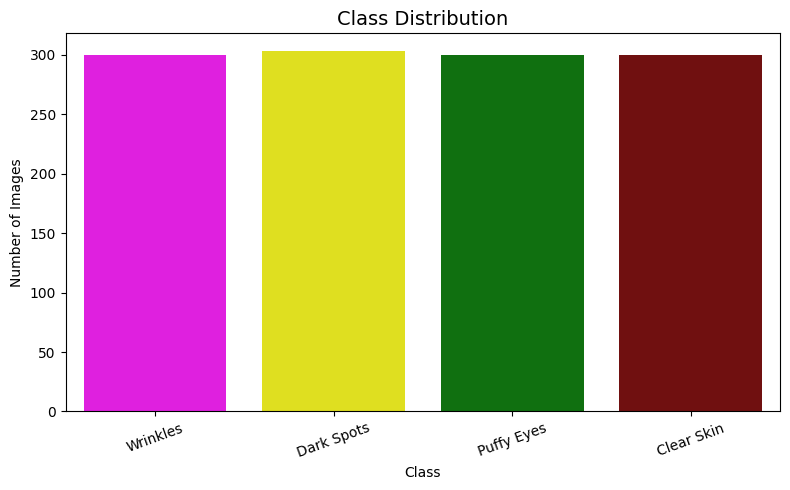

In [5]:
# Plotting how many images are present in each class
plt.figure(figsize=(8,5))

colors = ["magenta", "yellow", "green", "maroon"]

sns.countplot(
    data=df,
    x="label",
    hue="label",          
    palette=colors,
    legend=False          
)

plt.title("Class Distribution", fontsize=14)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()



In [6]:
!pip install tensorflow


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
#Import libraries for Module 2

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

#ImageDataGenerator for image augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


In [8]:
IMG_SIZE = 224
images = []
labels_list = []

for i, row in df.iterrows():
    img_path = row["filepath"]
    label = row["label"]

    img = Image.open(img_path).convert("RGB")
    img = img.resize((IMG_SIZE, IMG_SIZE))
    img_array = np.array(img) / 255.0   # normalize
    images.append(img_array)
    labels_list.append(label)

images = np.array(images)
print("Processed images shape:", images.shape)


Processed images shape: (1203, 224, 224, 3)


In [9]:
#using ImageDataGenerator to create modified images
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)


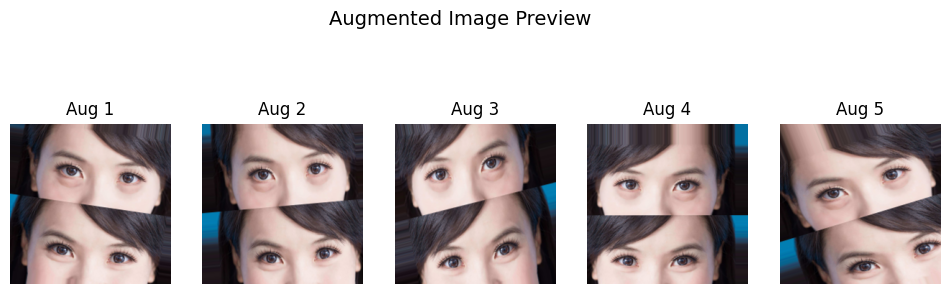

In [10]:
import random

random_index = random.randrange(len(images))
selected_image = images[random_index]

#adding extra dimension for ImageDataGenerator
image_array = np.expand_dims(selected_image, axis=0)
# We Generate 5 augmented images
augmented_batch = [next(datagen.flow(image_array))[0] for _ in range(5)]

plt.figure(figsize=(12, 4))
for i, img in enumerate(augmented_batch):
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Aug {i+1}")

plt.suptitle("Augmented Image Preview", fontsize=14)
plt.show()


In [11]:
label_map = {
    "Clear Skin": 0,
    "Dark Spots": 1,
    "Puffy Eyes": 2,
    "Wrinkles": 3
}

df["label_id"] = df["label"].map(label_map)

labels_numeric = df["label_id"].values
labels_onehot = to_categorical(labels_numeric, num_classes=4)

print("One-hot encoded shape:", labels_onehot.shape)
print(labels_onehot[:5])


One-hot encoded shape: (1203, 4)
[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


In [12]:
X_train, X_val, y_train, y_val = train_test_split(
    images,
    labels_onehot,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print("Training shape:", X_train.shape)
print("Validation shape:", X_val.shape)


Training shape: (962, 224, 224, 3)
Validation shape: (241, 224, 224, 3)


In [39]:

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

X_train = preprocess_input(X_train * 255.0)
X_val   = preprocess_input(X_val * 255.0)

print("MobileNetV2 preprocessing applied")


MobileNetV2 preprocessing applied


In [40]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt


In [41]:
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False


In [42]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(4, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)


In [43]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [44]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=8,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

checkpoint = ModelCheckpoint(
    "AIDermalScan_MobileNetV2_best.h5",
    monitor="val_accuracy",
    save_best_only=True
)

callbacks = [early_stop, reduce_lr, checkpoint]


In [45]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.2176 - loss: 1.8121

31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 759ms/step - accuracy: 0.2225 - loss: 1.7911 - val_accuracy: 0.2988 - val_loss: 1.4349 - learning_rate: 1.0000e-04
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.2849 - loss: 1.6190

31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 695ms/step - accuracy: 0.2994 - loss: 1.5428 - val_accuracy: 0.4481 - val_loss: 1.2600 - learning_rate: 1.0000e-04
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.4042 - loss: 1.3859

31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 679ms/step - accuracy: 0.4116 - loss: 1.3611 - val_accuracy: 0.5187 - val_loss: 1.1237 - learning_rate: 1.0000e-04
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.4482 - loss: 1.2333

31/31 ━━━━━━━━━━━━━━━━━━━━ 42s 717ms/step - accuracy: 0.4647 - loss: 1.2144 - val_accuracy: 0.5934 - val_loss: 1.0213 - learning_rate: 1.0000e-04
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.5080 - loss: 1.1266

31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 696ms/step - accuracy: 0.5364 - loss: 1.0850 - val_accuracy: 0.6473 - val_loss: 0.9446 - learning_rate: 1.0000e-04
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.5051 - loss: 1.1090

31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 704ms/step - accuracy: 0.5530 - loss: 1.0366 - val_accuracy: 0.6639 - val_loss: 0.8814 - learning_rate: 1.0000e-04
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.5809 - loss: 0.9744

31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 770ms/step - accuracy: 0.6040 - loss: 0.9485 - val_accuracy: 0.6805 - val_loss: 0.8339 - learning_rate: 1.0000e-04
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.6322 - loss: 0.8923

31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 747ms/step - accuracy: 0.6341 - loss: 0.8925 - val_accuracy: 0.6846 - val_loss: 0.7914 - learning_rate: 1.0000e-04
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.6152 - loss: 0.8959

31/31 ━━━━━━━━━━━━━━━━━━━━ 25s 792ms/step - accuracy: 0.6414 - loss: 0.8677 - val_accuracy: 0.7178 - val_loss: 0.7594 - learning_rate: 1.0000e-04
Epoch 10/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.6840 - loss: 0.8256

31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 762ms/step - accuracy: 0.6694 - loss: 0.8231 - val_accuracy: 0.7220 - val_loss: 0.7307 - learning_rate: 1.0000e-04
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.6966 - loss: 0.7511

31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 760ms/step - accuracy: 0.6788 - loss: 0.7758 - val_accuracy: 0.7261 - val_loss: 0.7083 - learning_rate: 1.0000e-04
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.7358 - loss: 0.7171

31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 770ms/step - accuracy: 0.7245 - loss: 0.7401 - val_accuracy: 0.7386 - val_loss: 0.6879 - learning_rate: 1.0000e-04
Epoch 13/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.6942 - loss: 0.7248

31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 732ms/step - accuracy: 0.7100 - loss: 0.7240 - val_accuracy: 0.7676 - val_loss: 0.6667 - learning_rate: 1.0000e-04
Epoch 14/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 733ms/step - accuracy: 0.7412 - loss: 0.6811 - val_accuracy: 0.7676 - val_loss: 0.6520 - learning_rate: 1.0000e-04
Epoch 15/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.7403 - loss: 0.6923

31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 739ms/step - accuracy: 0.7464 - loss: 0.6785 - val_accuracy: 0.7718 - val_loss: 0.6368 - learning_rate: 1.0000e-04
Epoch 16/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.7570 - loss: 0.6472

31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 731ms/step - accuracy: 0.7609 - loss: 0.6513 - val_accuracy: 0.7759 - val_loss: 0.6229 - learning_rate: 1.0000e-04
Epoch 17/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 743ms/step - accuracy: 0.7672 - loss: 0.6239 - val_accuracy: 0.7676 - val_loss: 0.6120 - learning_rate: 1.0000e-04
Epoch 18/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 731ms/step - accuracy: 0.7578 - loss: 0.6229 - val_accuracy: 0.7759 - val_loss: 0.5973 - learning_rate: 1.0000e-04
Epoch 19/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 775ms/step - accuracy: 0.7651 - loss: 0.6077 - val_accuracy: 0.7759 - val_loss: 0.5893 - learning_rate: 1.0000e-04
Epoch 20/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.7887 - loss: 0.5793

31/31 ━━━━━━━━━━━━━━━━━━━━ 39s 710ms/step - accuracy: 0.7921 - loss: 0.5682 - val_accuracy: 0.7801 - val_loss: 0.5813 - learning_rate: 1.0000e-04
Epoch 21/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.7915 - loss: 0.5921

31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 760ms/step - accuracy: 0.7848 - loss: 0.5912 - val_accuracy: 0.7884 - val_loss: 0.5715 - learning_rate: 1.0000e-04
Epoch 22/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 791ms/step - accuracy: 0.7786 - loss: 0.5529 - val_accuracy: 0.7842 - val_loss: 0.5625 - learning_rate: 1.0000e-04
Epoch 23/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 38s 705ms/step - accuracy: 0.7911 - loss: 0.5441 - val_accuracy: 0.7884 - val_loss: 0.5552 - learning_rate: 1.0000e-04
Epoch 24/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.8250 - loss: 0.4846

31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 777ms/step - accuracy: 0.8015 - loss: 0.5260 - val_accuracy: 0.7967 - val_loss: 0.5488 - learning_rate: 1.0000e-04
Epoch 25/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 740ms/step - accuracy: 0.8139 - loss: 0.5141 - val_accuracy: 0.7967 - val_loss: 0.5401 - learning_rate: 1.0000e-04
Epoch 26/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.7991 - loss: 0.5493

31/31 ━━━━━━━━━━━━━━━━━━━━ 25s 793ms/step - accuracy: 0.7994 - loss: 0.5365 - val_accuracy: 0.8050 - val_loss: 0.5341 - learning_rate: 1.0000e-04
Epoch 27/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 38s 692ms/step - accuracy: 0.8119 - loss: 0.5117 - val_accuracy: 0.8008 - val_loss: 0.5284 - learning_rate: 1.0000e-04
Epoch 28/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 736ms/step - accuracy: 0.8056 - loss: 0.5046 - val_accuracy: 0.8008 - val_loss: 0.5220 - learning_rate: 1.0000e-04
Epoch 29/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 697ms/step - accuracy: 0.8222 - loss: 0.4960 - val_accuracy: 0.8008 - val_loss: 0.5164 - learning_rate: 1.0000e-04
Epoch 30/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 740ms/step - accuracy: 0.8316 - loss: 0.4805 - val_accuracy: 0.8008 - val_loss: 0.5117 - learning_rate: 1.0000e-04
Epoch 31/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.8286 - loss: 0.4560

31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 754ms/step - accuracy: 0.8087 - loss: 0.4808 - val_accuracy: 0.8091 - val_loss: 0.5065 - learning_rate: 1.0000e-04
Epoch 32/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 760ms/step - accuracy: 0.8170 - loss: 0.4700 - val_accuracy: 0.8050 - val_loss: 0.5026 - learning_rate: 1.0000e-04
Epoch 33/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 765ms/step - accuracy: 0.8264 - loss: 0.4679 - val_accuracy: 0.8091 - val_loss: 0.4981 - learning_rate: 1.0000e-04
Epoch 34/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 742ms/step - accuracy: 0.8389 - loss: 0.4364 - val_accuracy: 0.8091 - val_loss: 0.4924 - learning_rate: 1.0000e-04
Epoch 35/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 778ms/step - accuracy: 0.8441 - loss: 0.4501 - val_accuracy: 0.8091 - val_loss: 0.4876 - learning_rate: 1.0000e-04
Epoch 36/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 734ms/step - accuracy: 0.8399 - loss: 0.4504 - val_accuracy: 0.8091 - val_loss: 0.4865 - learning_rate: 1.0000e-04
Epoch 37/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 41s 734ms/step - accuracy

31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 827ms/step - accuracy: 0.8389 - loss: 0.4394 - val_accuracy: 0.8133 - val_loss: 0.4780 - learning_rate: 1.0000e-04
Epoch 39/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 729ms/step - accuracy: 0.8254 - loss: 0.4321

31/31 ━━━━━━━━━━━━━━━━━━━━ 30s 982ms/step - accuracy: 0.8368 - loss: 0.4152 - val_accuracy: 0.8174 - val_loss: 0.4769 - learning_rate: 1.0000e-04
Epoch 40/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 38s 878ms/step - accuracy: 0.8430 - loss: 0.4330 - val_accuracy: 0.8133 - val_loss: 0.4713 - learning_rate: 1.0000e-04
Epoch 41/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.8501 - loss: 0.4097

31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 781ms/step - accuracy: 0.8555 - loss: 0.4025 - val_accuracy: 0.8216 - val_loss: 0.4678 - learning_rate: 1.0000e-04
Epoch 42/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 39s 710ms/step - accuracy: 0.8565 - loss: 0.4085 - val_accuracy: 0.8216 - val_loss: 0.4659 - learning_rate: 1.0000e-04
Epoch 43/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 41s 700ms/step - accuracy: 0.8597 - loss: 0.3923 - val_accuracy: 0.8216 - val_loss: 0.4602 - learning_rate: 1.0000e-04
Epoch 44/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 676ms/step - accuracy: 0.8514 - loss: 0.3981 - val_accuracy: 0.8174 - val_loss: 0.4575 - learning_rate: 1.0000e-04
Epoch 45/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.8396 - loss: 0.4350

31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 783ms/step - accuracy: 0.8503 - loss: 0.4085 - val_accuracy: 0.8257 - val_loss: 0.4546 - learning_rate: 1.0000e-04
Epoch 46/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.8488 - loss: 0.4030

31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 744ms/step - accuracy: 0.8534 - loss: 0.3885 - val_accuracy: 0.8340 - val_loss: 0.4527 - learning_rate: 1.0000e-04
Epoch 47/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 757ms/step - accuracy: 0.8628 - loss: 0.3850 - val_accuracy: 0.8216 - val_loss: 0.4496 - learning_rate: 1.0000e-04
Epoch 48/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 38s 661ms/step - accuracy: 0.8462 - loss: 0.3910 - val_accuracy: 0.8340 - val_loss: 0.4466 - learning_rate: 1.0000e-04
Epoch 49/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 721ms/step - accuracy: 0.8649 - loss: 0.3765 - val_accuracy: 0.8340 - val_loss: 0.4433 - learning_rate: 1.0000e-04
Epoch 50/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 682ms/step - accuracy: 0.8586 - loss: 0.3690 - val_accuracy: 0.8340 - val_loss: 0.4401 - learning_rate: 1.0000e-04


In [49]:
from tensorflow.keras.models import load_model

model = load_model("AIDermalScan_MobileNetV2_best.h5")  
print("Best fine-tuned model loaded")


Best fine-tuned model loaded


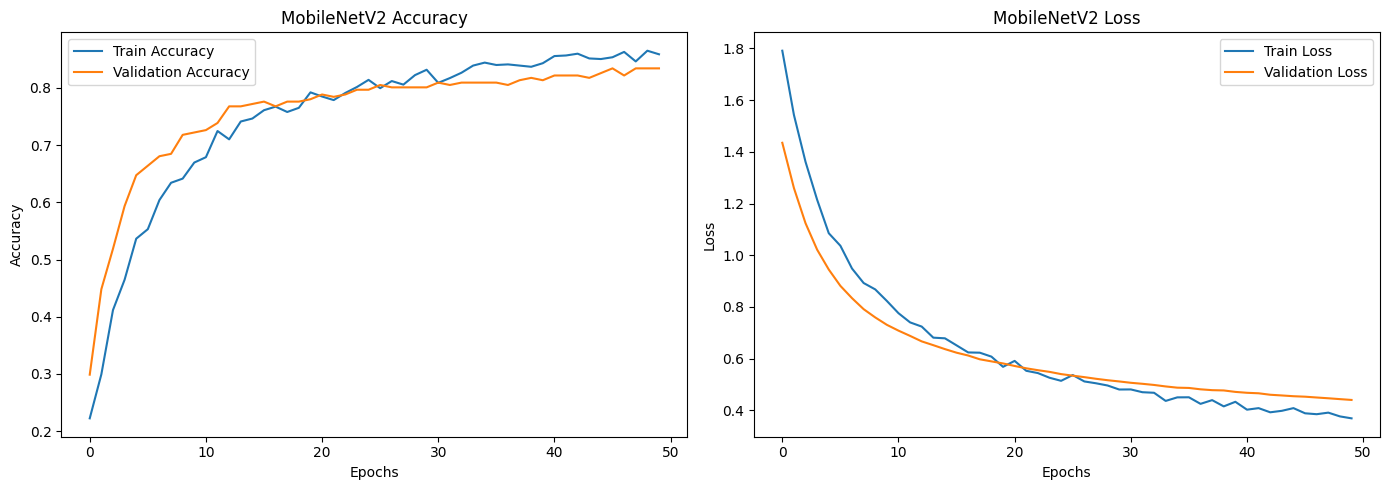

In [50]:
import matplotlib.pyplot as plt

n1 = len(history.history["accuracy"])


epochs_1 = range(n1)
epochs_2 = range(n1, n1 )

plt.figure(figsize=(14,5))

#accuracy
plt.subplot(1,2,1)

# Before fine-tuning
plt.plot(epochs_1, history.history["accuracy"], label="Train Accuracy")
plt.plot(epochs_1, history.history["val_accuracy"], label="Validation Accuracy")


plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("MobileNetV2 Accuracy")
plt.legend()

# loss
plt.subplot(1,2,2)

# Before fine-tuning
plt.plot(epochs_1, history.history["loss"], label="Train Loss")
plt.plot(epochs_1, history.history["val_loss"], label="Validation Loss")


plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("MobileNetV2 Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
model.save("AIDermalScan_MobileNetV2_Final.h5")
print("Final model saved")


EfficientNetB0

In [28]:
from tensorflow.keras.applications.efficientnet import preprocess_input

X_train_eff = preprocess_input(X_train * 255.0)
X_val_eff   = preprocess_input(X_val * 255.0)


In [29]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [30]:
base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False


In [31]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
output = Dense(4, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)


In [32]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [33]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=4, min_lr=1e-6),
    ModelCheckpoint(
        "AIDermalScan_EfficientNetB0_best.keras",
        monitor="val_accuracy",
        save_best_only=True
    )
]


In [34]:
history_1 = model.fit(
    X_train_eff,
    y_train,
    validation_data=(X_val_eff, y_val),
    epochs=25,
    batch_size=32,
    callbacks=callbacks
)


Epoch 1/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.2578 - loss: 1.5686 - val_accuracy: 0.2988 - val_loss: 1.4146 - learning_rate: 1.0000e-04
Epoch 2/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.3347 - loss: 1.4586 - val_accuracy: 0.3320 - val_loss: 1.3310 - learning_rate: 1.0000e-04
Epoch 3/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.3555 - loss: 1.4224 - val_accuracy: 0.4274 - val_loss: 1.2617 - learning_rate: 1.0000e-04
Epoch 4/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.3992 - loss: 1.3607 - val_accuracy: 0.4855 - val_loss: 1.2040 - learning_rate: 1.0000e-04
Epoch 5/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.4304 - loss: 1.3179 - val_accuracy: 0.5353 - val_loss: 1.1557 - learning_rate: 1.0000e-04
Epoch 6/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 37s 979ms/step - accuracy: 0.4719 - loss: 1.2586 - val_accuracy: 0.5519 - val_loss: 1.1187 - learning_rate: 1.0000e-04
Epoch 7/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 30s 977ms/step - accuracy: 0.4854 -

In [35]:

for layer in base_model.layers[-20:]:
    layer.trainable = True


In [36]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [37]:
history_2 = model.fit(
    X_train_eff,
    y_train,
    validation_data=(X_val_eff, y_val),
    epochs=15,
    batch_size=32,
    callbacks=callbacks
)


Epoch 1/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.5852 - loss: 1.0492 - val_accuracy: 0.7178 - val_loss: 0.8560 - learning_rate: 1.0000e-05
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.6268 - loss: 1.0031 - val_accuracy: 0.6722 - val_loss: 0.9025 - learning_rate: 1.0000e-05
Epoch 3/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.5998 - loss: 0.9879 - val_accuracy: 0.6515 - val_loss: 0.9238 - learning_rate: 1.0000e-05
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.6206 - loss: 0.9610 - val_accuracy: 0.6556 - val_loss: 0.9314 - learning_rate: 1.0000e-05
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6538 - loss: 0.9406 - val_accuracy: 0.6598 - val_loss: 0.9378 - learning_rate: 3.0000e-06
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.6528 - loss: 0.9421 - val_accuracy: 0.6515 - val_loss: 0.9634 - learning_rate: 3.0000e-06


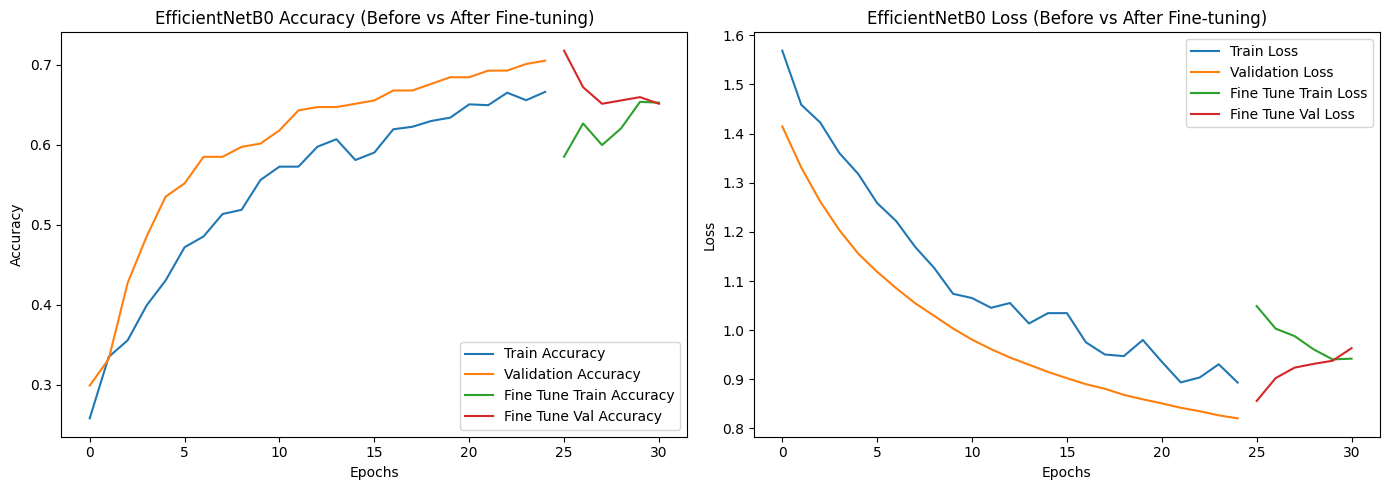

In [62]:
import matplotlib.pyplot as plt

n1 = len(history_1.history["accuracy"])
n2 = len(history_2.history["accuracy"])

epochs_1 = range(n1)
epochs_2 = range(n1, n1 + n2)

plt.figure(figsize=(14,5))

# accuracy
plt.subplot(1,2,1)

# Before fine-tuning
plt.plot(epochs_1, history_1.history["accuracy"], label="Train Accuracy")
plt.plot(epochs_1, history_1.history["val_accuracy"], label="Validation Accuracy")

# After fine-tuning
plt.plot(epochs_2, history_2.history["accuracy"], label="Fine Tune Train Accuracy")
plt.plot(epochs_2, history_2.history["val_accuracy"], label="Fine Tune Val Accuracy")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("EfficientNetB0 Accuracy (Before vs After Fine-tuning)")
plt.legend()

# loss
plt.subplot(1,2,2)

# Before fine-tuning
plt.plot(epochs_1, history_1.history["loss"], label="Train Loss")
plt.plot(epochs_1, history_1.history["val_loss"], label="Validation Loss")

# After fine-tuning
plt.plot(epochs_2, history_2.history["loss"], label="Fine Tune Train Loss")
plt.plot(epochs_2, history_2.history["val_loss"], label="Fine Tune Val Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("EfficientNetB0 Loss (Before vs After Fine-tuning)")
plt.legend()

plt.tight_layout()
plt.show()


In [63]:
model.save("AIDermalScan_EfficientNetB0_Finetuned.h5")
print("saved")


saved


ResNet50

In [73]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [74]:
X_train_res = preprocess_input(X_train * 255.0)
X_val_res   = preprocess_input(X_val * 255.0)


In [75]:
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False


In [76]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
output = Dense(4, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)


In [77]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [78]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=4, min_lr=1e-6),
    ModelCheckpoint(
        "AIDermalScan_ResNet50_best.h5",
        monitor="val_accuracy",
        save_best_only=True
    )
]


In [80]:
history = model.fit(
    X_train_res,
    y_train,
    validation_data=(X_val_res, y_val),
    epochs=20,
    batch_size=32,
    callbacks=callbacks
)


Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4663 - loss: 1.3379

31/31 ━━━━━━━━━━━━━━━━━━━━ 110s 3s/step - accuracy: 0.4761 - loss: 1.2640 - val_accuracy: 0.5892 - val_loss: 1.0490 - learning_rate: 1.0000e-04
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5253 - loss: 1.1875

31/31 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - accuracy: 0.5291 - loss: 1.1596 - val_accuracy: 0.6515 - val_loss: 0.9397 - learning_rate: 1.0000e-04
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5543 - loss: 1.0729

31/31 ━━━━━━━━━━━━━━━━━━━━ 131s 3s/step - accuracy: 0.5832 - loss: 1.0110 - val_accuracy: 0.6846 - val_loss: 0.8503 - learning_rate: 1.0000e-04
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6542 - loss: 0.9151

31/31 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.6497 - loss: 0.9083 - val_accuracy: 0.7344 - val_loss: 0.7910 - learning_rate: 1.0000e-04
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6931 - loss: 0.7854

31/31 ━━━━━━━━━━━━━━━━━━━━ 176s 4s/step - accuracy: 0.6663 - loss: 0.8217 - val_accuracy: 0.7427 - val_loss: 0.7453 - learning_rate: 1.0000e-04
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6779 - loss: 0.8504

31/31 ━━━━━━━━━━━━━━━━━━━━ 113s 3s/step - accuracy: 0.6881 - loss: 0.8196 - val_accuracy: 0.7510 - val_loss: 0.7112 - learning_rate: 1.0000e-04
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7161 - loss: 0.7205

31/31 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.7100 - loss: 0.7372 - val_accuracy: 0.7635 - val_loss: 0.6820 - learning_rate: 1.0000e-04
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6897 - loss: 0.7408

31/31 ━━━━━━━━━━━━━━━━━━━━ 137s 3s/step - accuracy: 0.6913 - loss: 0.7320 - val_accuracy: 0.7759 - val_loss: 0.6550 - learning_rate: 1.0000e-04
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7148 - loss: 0.7214

31/31 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - accuracy: 0.7443 - loss: 0.6665 - val_accuracy: 0.7842 - val_loss: 0.6322 - learning_rate: 1.0000e-04
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.7484 - loss: 0.6487 - val_accuracy: 0.7842 - val_loss: 0.6149 - learning_rate: 1.0000e-04
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7487 - loss: 0.6668

31/31 ━━━━━━━━━━━━━━━━━━━━ 106s 3s/step - accuracy: 0.7412 - loss: 0.6552 - val_accuracy: 0.8050 - val_loss: 0.5986 - learning_rate: 1.0000e-04
Epoch 12/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7580 - loss: 0.6119

31/31 ━━━━━━━━━━━━━━━━━━━━ 151s 4s/step - accuracy: 0.7630 - loss: 0.6080 - val_accuracy: 0.8091 - val_loss: 0.5833 - learning_rate: 1.0000e-04
Epoch 13/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.7775 - loss: 0.5683 - val_accuracy: 0.8091 - val_loss: 0.5706 - learning_rate: 1.0000e-04
Epoch 14/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7575 - loss: 0.6103

31/31 ━━━━━━━━━━━━━━━━━━━━ 164s 4s/step - accuracy: 0.7775 - loss: 0.5693 - val_accuracy: 0.8133 - val_loss: 0.5594 - learning_rate: 1.0000e-04
Epoch 15/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 128s 4s/step - accuracy: 0.7734 - loss: 0.5673 - val_accuracy: 0.8050 - val_loss: 0.5494 - learning_rate: 1.0000e-04
Epoch 16/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - accuracy: 0.8046 - loss: 0.5423 - val_accuracy: 0.8050 - val_loss: 0.5384 - learning_rate: 1.0000e-04
Epoch 17/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8088 - loss: 0.5152

31/31 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.8129 - loss: 0.5152 - val_accuracy: 0.8174 - val_loss: 0.5290 - learning_rate: 1.0000e-04
Epoch 18/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8001 - loss: 0.5044

31/31 ━━━━━━━━━━━━━━━━━━━━ 145s 5s/step - accuracy: 0.8119 - loss: 0.4909 - val_accuracy: 0.8216 - val_loss: 0.5200 - learning_rate: 1.0000e-04
Epoch 19/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 165s 5s/step - accuracy: 0.8108 - loss: 0.5052 - val_accuracy: 0.8133 - val_loss: 0.5119 - learning_rate: 1.0000e-04
Epoch 20/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 191s 5s/step - accuracy: 0.8160 - loss: 0.4913 - val_accuracy: 0.8216 - val_loss: 0.5044 - learning_rate: 1.0000e-04


In [81]:
for layer in model.layers:
    layer.trainable = False


In [82]:
for layer in model.layers[-15:-3]:
    layer.trainable = True


In [83]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [84]:
history_2 = model.fit(
    X_train_res,
    y_train,
    validation_data=(X_val_res, y_val),
    epochs=5,
    batch_size=32,
    callbacks=callbacks
)


Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8397 - loss: 0.4469

31/31 ━━━━━━━━━━━━━━━━━━━━ 197s 6s/step - accuracy: 0.8306 - loss: 0.4577 - val_accuracy: 0.8340 - val_loss: 0.4833 - learning_rate: 1.0000e-05
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8351 - loss: 0.4518

31/31 ━━━━━━━━━━━━━━━━━━━━ 203s 6s/step - accuracy: 0.8399 - loss: 0.4194 - val_accuracy: 0.8382 - val_loss: 0.4645 - learning_rate: 1.0000e-05
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8559 - loss: 0.4153

31/31 ━━━━━━━━━━━━━━━━━━━━ 191s 6s/step - accuracy: 0.8586 - loss: 0.3987 - val_accuracy: 0.8465 - val_loss: 0.4475 - learning_rate: 1.0000e-05
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8568 - loss: 0.3897

31/31 ━━━━━━━━━━━━━━━━━━━━ 170s 6s/step - accuracy: 0.8753 - loss: 0.3593 - val_accuracy: 0.8548 - val_loss: 0.4353 - learning_rate: 1.0000e-05
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8856 - loss: 0.3148

31/31 ━━━━━━━━━━━━━━━━━━━━ 180s 6s/step - accuracy: 0.8825 - loss: 0.3257 - val_accuracy: 0.8589 - val_loss: 0.4242 - learning_rate: 1.0000e-05


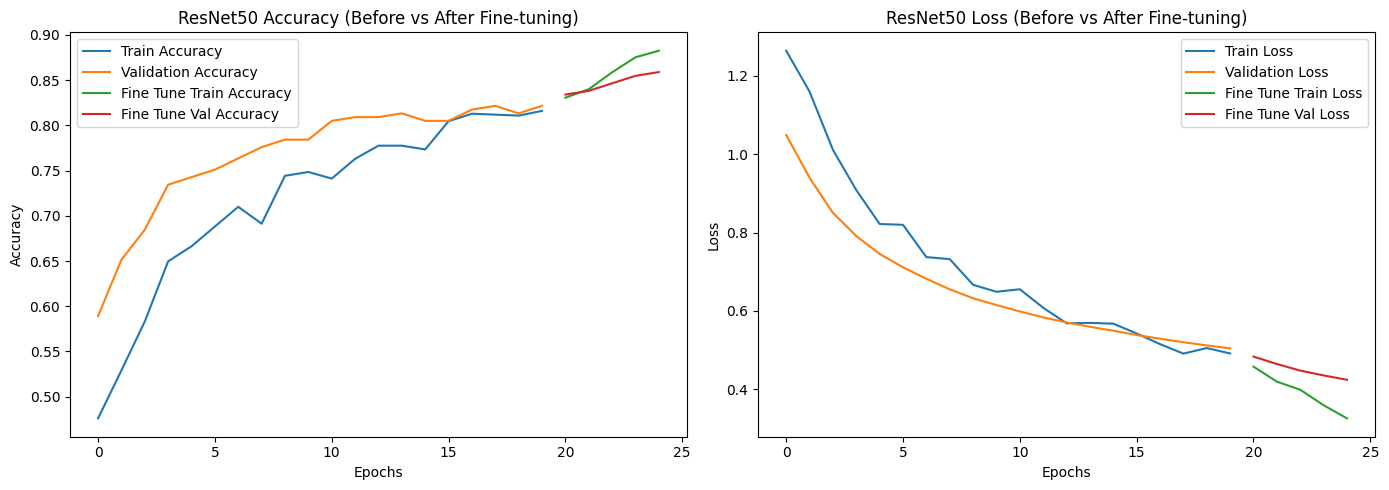

In [86]:
import matplotlib.pyplot as plt

n1 = len(history.history["accuracy"])
n2 = len(history_2.history["accuracy"])

epochs_1 = range(n1)
epochs_2 = range(n1, n1 + n2)

plt.figure(figsize=(14,5))

#accuracy
plt.subplot(1,2,1)

# Before fine-tuning
plt.plot(epochs_1, history.history["accuracy"], label="Train Accuracy")
plt.plot(epochs_1, history.history["val_accuracy"], label="Validation Accuracy")

# After fine-tuning
plt.plot(epochs_2, history_2.history["accuracy"], label="Fine Tune Train Accuracy")
plt.plot(epochs_2, history_2.history["val_accuracy"], label="Fine Tune Val Accuracy")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("ResNet50 Accuracy (Before vs After Fine-tuning)")
plt.legend()

# loss
plt.subplot(1,2,2)

# Before fine-tuning
plt.plot(epochs_1, history.history["loss"], label="Train Loss")
plt.plot(epochs_1, history.history["val_loss"], label="Validation Loss")

# After fine-tuning
plt.plot(epochs_2, history_2.history["loss"], label="Fine Tune Train Loss")
plt.plot(epochs_2, history_2.history["val_loss"], label="Fine Tune Val Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("ResNet50 Loss (Before vs After Fine-tuning)")
plt.legend()

plt.tight_layout()
plt.show()


In [87]:
from tensorflow.keras.models import load_model
model = load_model("AIDermalScan_ResNet50_best.h5")


In [88]:
model.save("AIDermalScan_ResNet50_Final.h5")


Haar Cascade 

In [61]:
import cv2
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt

# Load skin classification model
skin_model = tf.keras.models.load_model("AIDermalScan_ResNet50_Final.h5")

class_names = ['clear skin', 'dark spots', 'puffy eyes', 'wrinkles']


In [62]:
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

assert not face_cascade.empty(), "Haar Cascade not loaded"


In [63]:
def estimate_age(predicted_class, confidence):
    age_map = {
        "clear skin": (18, 25),
        "dark spots": (25, 35),
        "puffy eyes": (30, 45),
        "wrinkles": (45, 60)
    }

    low, high = age_map[predicted_class]
    age = int(low + (1 - confidence / 100) * (high - low))
    return age


In [64]:
def run_inference(image_path, model, class_names):
    img = cv2.imread(image_path)
    assert img is not None, "Image not found"

    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.3,
        minNeighbors=5,
        minSize=(80, 80)
    )

    for (x, y, w, h) in faces:
        face = rgb[y:y+h, x:x+w]
        face = cv2.resize(face, (224, 224)) / 255.0
        face = np.expand_dims(face, axis=0)

        preds = model.predict(face)[0]
        class_index = np.argmax(preds)

        label = class_names[class_index]
        confidence = preds[class_index] * 100
        age = estimate_age(label, confidence)

        text = f"{label}: {confidence:.2f}% | Age: {age}"

        cv2.rectangle(rgb, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(
            rgb, text, (x, y-10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.8,
            (255, 0, 0), 2
        )

    return rgb


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


(np.float64(-0.5), np.float64(639.5), np.float64(639.5), np.float64(-0.5))

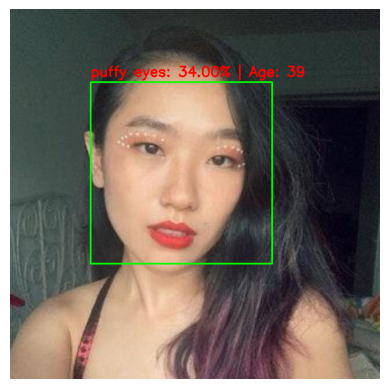

In [65]:
img_path = r"C:\Users\Priya\OneDrive\Desktop\AI DermalScan\dataset\Clear Skin\clear_skin_035.jpg"

output_img = run_inference(img_path, skin_model, class_names)

plt.imshow(output_img)
plt.axis("off")
